## Лабораторна робота №2: "Імплементація алгоритмів стиснення"

Склад команди та розподіл виконаних завдань:
Валігурський Антон, Денисова Ірина, Кравчук Андрій
- Валігурський Антон - lzw, deflate
- Денисова Ірина - lz77
- Кравчук Андрій - haffman 

Для кожного з алгоритмів поданих нижче
- опишіть як працює алгорит
- напишіть класи з методами encode та decode
- перевірте правильність кодування та декодування
- дослідіть час виконання коду в залежності від розмірів вхідних даних
- оцініть ступінь стиснення(у відсотка) в залежності від розмірів
- напишіть висновок про ефективність різних алгоритмів та умови за яких той чи інший алгоритм дають кращий результат

In [165]:
import random, string
import matplotlib.pyplot as plt
from time import time

def randomword(length):
   letters = string.ascii_lowercase
   return ''.join(random.choice(letters) for i in range(length))

lengths = range(2,10001, 1000)


# Алгоритм Гаффмана

В цьому алгоритмі доцільно імплементувати клас node та додаткові функції в Huffman для побудови дерева кодування

In [166]:
class Node:
    def __init__(self, symbol, frequency, left=None, right=None):
        self.symbol = symbol
        self.frequency = frequency
        self.left = left
        self.right = right
    
    def __repr__(self):
        return f'Node({self.frequency}, {self.symbol})'

class Huffman:
    
    def build_tree(self, text:str) -> Node:
        frequencies = {}
        for symbol in text:
            frequencies[symbol] = frequencies.get(symbol, 0) + 1
        nodes = [Node(char, freq) for char, freq in frequencies.items()]
        while len(nodes) > 1:
            nodes = sorted(nodes, key=lambda x: x.frequency)
            left = nodes.pop(0)
            right = nodes.pop(0)
            parent = Node(None, left.frequency + right.frequency)
            parent.left = left
            parent.right = right
            nodes.append(parent)
        return nodes[0]
    
    def calculate_codes(self, root: Node, curr_node = '', codes = {}) -> dict[str, str]:
        if root is None:
            return
        if root.symbol is not None:
            codes[root.symbol] = curr_node
        self.calculate_codes(root.left, curr_node + '0', codes)
        self.calculate_codes(root.right, curr_node + '1', codes)
        return codes

    def encode(self, text: str) -> tuple[str, dict[str, str]]:
        tree = self.build_tree(text)
        codes = self.calculate_codes(tree)
        return ''.join([codes[symbol] for symbol in text])

    def decode(self, code: str, coding_dict: dict[str, str]):
        decoded = ''
        curr_code = ''
        for bit in code:
            curr_code += bit
            for char, code in coding_dict.items():
                if code == curr_code:
                    decoded += char
                    curr_code = ""
                    break
        return decoded

to_code = randomword(100)
h = Huffman()
tree = h.build_tree(to_code)
codes = h.calculate_codes(tree)
enccoded = h.encode(to_code)
decoded = h.decode(h.encode(to_code), codes) 

# Алгоритм LZW

In [167]:
class LZW:
    def encode(self, text: str) -> tuple[str, list]:
        i = 0
        len_ = len(text)
        code = []

        start_dict = list(set(text))
        dict_ = start_dict[:]

        new_entry = ""
        while i < len_:
            new_entry += text[i]
            i += 1
            if new_entry not in dict_:
                dict_.append(new_entry)
                code.append(dict_.index(new_entry[:-1]))
                new_entry = ""
                i -= 1
                
        if new_entry not in dict_:
            dict_.append(new_entry)
        code.append(dict_.index(new_entry))
        
                
        return code, start_dict

        
    def decode(self, code: str, coding_dict: list) -> str:
        decoded_text = ""
        i = 0

        for symb in code:
            symb = int(symb)
            if int(symb) >= len(coding_dict):
                while len(coding_dict) <= symb:
                    new_entry = decoded_text[i]
                    i += 1
                    while i < len(decoded_text) and new_entry in coding_dict:
                        new_entry += decoded_text[i]
                        i += 1
                    if new_entry in coding_dict:
                        for new_char in new_entry:
                            new_entry += new_char
                            i+=1
                            if new_entry not in coding_dict:
                                break

                    coding_dict.append(new_entry)
                    i -= 1
            decoded_text += coding_dict[symb]

        return decoded_text







# Алгоритм LZ77

Потрібно заміряти розміри саме тексту, проте для роботи доцільно використовувати список тюплів, тому для зручності варто імплементувати додаткові алгоритми _text2list та _list2text

In [168]:
class LZ77:
    def __init__(self, window_size: int):
        self.window_size = window_size

    def encode(self, text):
        """
        Encoding
        """
        compressed = []
        index = 0

        while index < len(text):
            best_offset = -1
            best_length = -1
            best_match = ''

            # Search for the longest match in the sliding window
            for length in range(1, min(len(text) - index, self.window_size)):
                substring = text[index:index + length]
                offset = text.rfind(substring, max(0, index - self.window_size), index)

                if offset != -1 and length > best_length:
                    best_offset = index - offset
                    best_length = length
                    best_match = substring

            if best_match:
                # Add the (offset, length, next_character) tuple to the compressed data
                compressed.append((best_offset, best_length, text[index + best_length]))
                index += best_length + 1
            else:
                # No match found, add a zero-offset tuple
                compressed.append((0, 0, text[index]))
                index += 1

        return compressed

    def decode(self, encoded_list: list) -> str:
        """
        Decoding
        """
        result = ""
        for item in encoded_list:
            offset, length, next_char = item
            result += result[-offset:][:length] + next_char
        return result


# Алгоритм Deflate

In [187]:
class Deflate:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size

    def encode(self, text: str) -> str:

        tree = Huffman().build_tree(text)
        codes = Huffman().calculate_codes(tree)
        enccoded = LZ77(self.buffer_size).encode(Huffman().encode(text))
        
        return enccoded,codes

                
        # return LZ77(self.buffer_size).encode(enccoded), codes

    def decode(self, code: list, codes: dict) -> str:

        print(codes)
        return Huffman().decode(LZ77(self.buffer_size).decode(code),codes)

    
text = "zxc"
deflate = Deflate(5)

encoded_text, codes_dict=deflate.encode(text)
decoded = deflate.decode(encoded_text, codes_dict)
print(decoded)



{'c': '0', 'p': '0001', 'o': '0010', 'f': '01', 's': '10', 'v': '00111', 'd': '00', 'x': '11', 'i': '0110', 'j': '0111', 'g': '10000', 'e': '10001', 'm': '10010', 'w': '10011', 'u': '10100', 'y': '10101', 'z': '10', 'l': '1100', 'k': '11010', 'n': '0', 't': '11100', 'r': '11101', 'h': '11110', 'a': '11', 'q': '1111110', 'b': '1111111'}
sxc


# Testing

LZW effectivenes: 0.5
LZ77 effectiveness: 0.1111111111111111
LZW effectivenes: 0.7383935151068534
LZ77 effectiveness: 0.13159968479117415
LZW effectivenes: 0.7835616438356164
LZ77 effectiveness: 0.129932502596054
LZW effectivenes: 0.8752186588921282
LZ77 effectiveness: 0.13246844938663843
LZW effectivenes: 0.9204231830726771
LZ77 effectiveness: 0.13171406003159558
LZW effectivenes: 0.9346038863976084
LZ77 effectiveness: 0.13166969385874858
LZW effectivenes: 0.9765701269118126
LZ77 effectiveness: 0.1319004922644163
LZW effectivenes: 0.9472402597402597
LZ77 effectiveness: 0.13213315217391305
LZW effectivenes: 0.9861966970667981
LZ77 effectiveness: 0.13135043745178182
LZW effectivenes: 0.9821077896574296
LZ77 effectiveness: 0.13155625703304252


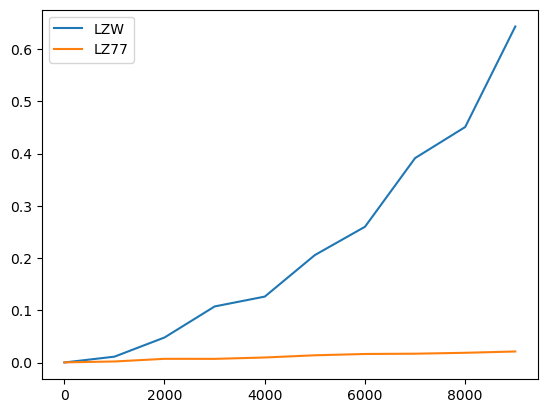

In [189]:
X = [i for i in lengths]
Y_LZW = []
Y_HUFFMAN = []
Y_LZ77 = []

for i in lengths:

    to_code = randomword(i)
    start = time()
    code, dict_ = LZW().encode(to_code)
    decoded = LZW().decode(code, dict_)
    Y_LZW.append(time()-start)
    assert to_code == decoded
    
    print("LZW effectivenes:",i / (len(code) + len(dict_)))
    
    start = time()
    lz777 = LZ77(5)
    encoded = lz777.encode(to_code)
    decoded = lz777.decode(encoded)
    Y_LZ77.append(time()-start)
    assert decoded == to_code
    
    print("LZ77 effectiveness:", i / (9*len(encoded)))
    
    


    
    
plt.plot(X, Y_LZW, label = "LZW")
# plt.plot(X, Y_HUFFMAN, label = "HUFFMAN")
plt.plot(X, Y_LZ77, label = "LZ77")
plt.xlabel = "length of string"
plt.ylabel = "time perfomance"

plt.legend()
plt.show()


### LZW
Очевидно, що зі зростанням кількості елементів в повідомленні, час стиснення відповідно зростає. На жаль, через повільнісь мови програмування Python нам не вдастся перевірити ефективність стиснення на повну, адже алгоритм розкриваєтсья на повну потужність на великих файлах, таких як картинки, в яких дуже багато повторен. Це можна довести тим, що зі збільшенням елементів відслідковується збільшення ефективності стиснення.


# LZ77
Метод encode сканує текст та створює стиснену версію, використовуючи трійки (зсув, довжина, наступний символ). Для кожної позиції у тексті, алгоритм шукає найдовший збіг вікном заданого розміру, позначає його як трійку і зсувається далі. Якщо збіг не знайдено, то додається трійка з нульовим зсувом.

Метод decode використовує закодовані трійки для відновлення оригінального тексту. Для кожної трійки він використовує зсув та довжину для вибору підстрічки з попередніх символів та додає наступний символ.

Н амою думку, цей алгоритм ефективно стискує повторювані фрагменти в тексті, зменшуючи загальний об'єм інформації. Однак для деяких видів даних та текстів інші алгоритми стиснення можуть бути більш ефективними.